# Q3. Regression

In [55]:
import jax.numpy as jnp
from random import randint
from jax import random, grad
from matplotlib import pyplot as plt

In [2]:
def generate_random_seed():
    return randint(0, 10000)

In [3]:
def target_f1(x, sigma_true=0.3):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    
    return (2 * x + sigma_true * noise).ravel()

In [103]:
def norm(a: float):
    return (a * a) ** 0.5

def element_wise_norm(x):
    shape = x.shape
    return jnp.array([norm(el) for el in x.ravel()]).reshape(shape)
  
def element_wise_sin(x):
    shape = x.shape

    return jnp.sin(x.ravel()).reshape(shape)


In [32]:
def target_f2(x: jnp.ndarray):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    y = 2 * x + element_wise_norm(x) * 0.3 * noise
    
    return y.ravel()

In [33]:
def target_f3(x):
    key = random.PRNGKey(generate_random_seed())
    noise = random.normal(key, shape=x.shape)
    y = 2 * x + 5 * element_wise_sin(x * 0.5) + element_wise_norm(x) * 0.3 * noise
    
    return y.ravel()

## Sample data from the target functions 

In [34]:
def sample_batch(target_f, batch_size):
    key = random.PRNGKey(generate_random_seed())
    x = random.uniform(key, shape=(1, batch_size), minval=0., maxval=20.)
    y = target_f(x)
    
    return x, y

## Test assumptions about your dimensions

In [35]:
n = 200
m = 1

for target_f in [target_f1, target_f2, target_f3]:
    x, y = sample_batch(target_f, n)
    assert x.shape == (m, n)
    assert y.shape == (n,)

print('Yaay!')

Yaay!


## Plot the target functions

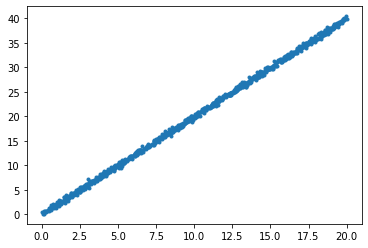

In [36]:
x, y = sample_batch(target_f1, 1000)

plt.plot(x[0], y, '.');

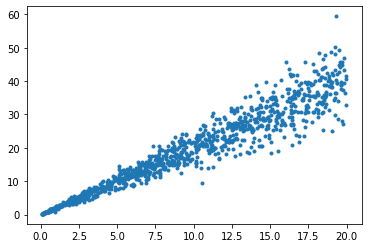

In [37]:
x, y = sample_batch(target_f2, 1000)

plt.plot(x[0], y, '.');

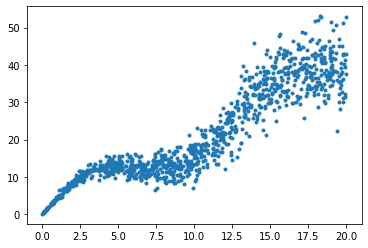

In [38]:
x, y = sample_batch(target_f3, 1000)

plt.plot(x[0], y, '.');

## Linear regression model with $\hat{\beta}$ MLE

In [12]:
from jax.numpy.linalg import inv

def beta_mle(X, y):
    beta = inv(X.dot(X.T)) @ X @ y
    
    return beta

In [13]:
n = 1000

print(beta_mle(*sample_batch(target_f1, n)))

[2.00003]


In [14]:
n = 1000

print(beta_mle(*sample_batch(target_f2, n)))

[1.9851127]


In [15]:
n = 1000

print(beta_mle(*sample_batch(target_f3, n)))

[2.0806715]


## Plot the MLE linear regression model

In [16]:
n = 200
X, y = sample_batch(target_f1, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

In [17]:
def sort_data(X, y, y_hat):
    """
    Due to the problem I had with shading I had to sort the data first and then
    plot the results...
    """
    order = jnp.argsort(X)

    return X[order], y[order], y_hat[order]

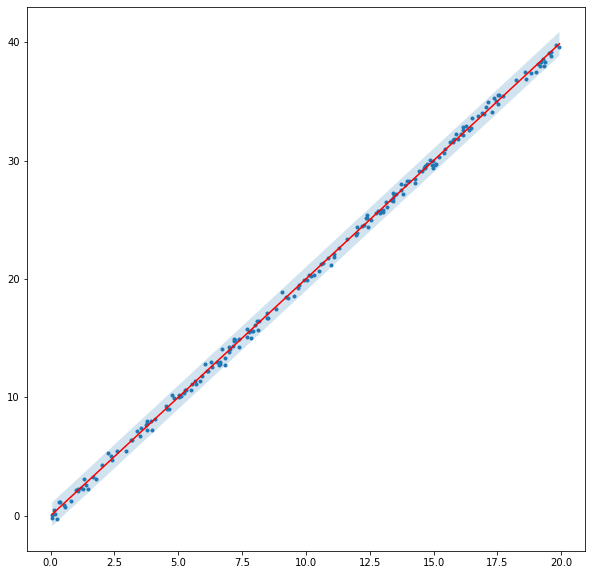

In [18]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [19]:
n = 200
X, y = sample_batch(target_f2, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

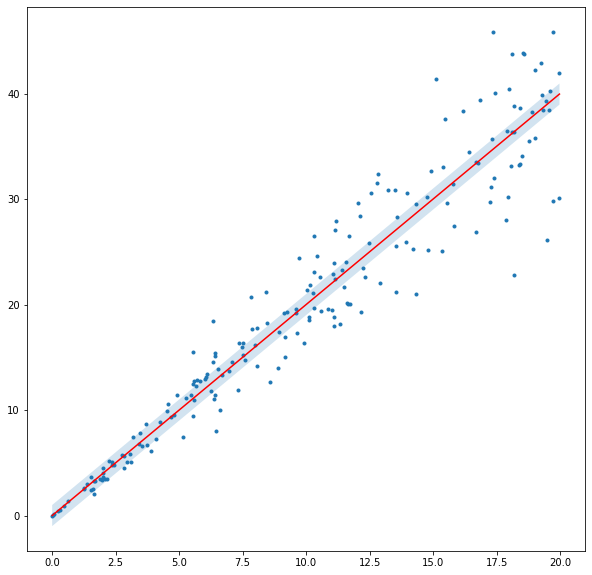

In [20]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)
plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [21]:
n = 200
X, y = sample_batch(target_f3, n)
beta_hat = beta_mle(X, y)
y_hat = (X.T @ beta_hat).ravel()

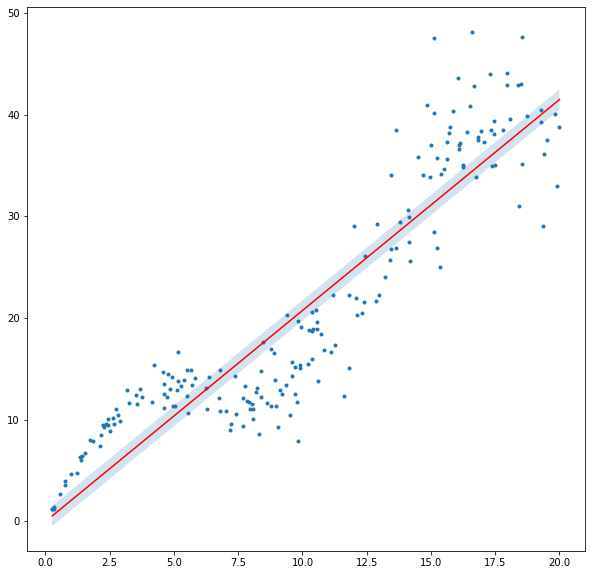

In [22]:
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)
plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, y_hat_sorted.copy()+uncertainty, alpha=0.2);

## Log-likelihood of Data under Model

In [99]:
from math import pi

def gaussian_log_likelihood(mu, sigma, x):    
    return -0.5 * jnp.log(2 * pi) - jnp.log(sigma) - 0.5 * ((x - mu) / sigma) ** 2


## Test Gaussian likelihood against standard implementation

In [100]:
from jax.scipy.stats import norm

x = np.random.randn()
mu = np.random.randn()
sigma = np.random.rand()
assert gaussian_log_likelihood(mu, sigma, x).shape == ()
assert abs(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

x = np.random.randn(100)
mu = np.random.randn()
sigma = np.random.rand()
assert gaussian_log_likelihood(mu, sigma, x).shape == (100,)
assert np.linalg.norm(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

x = np.random.randn(10)
mu = np.random.randn(10)
sigma = np.random.rand(10)
assert gaussian_log_likelihood(mu, sigma, x).shape == (10,)
assert np.linalg.norm(gaussian_log_likelihood(mu, sigma, x) - norm.logpdf(x, mu, sigma)) < 1e-2

print('Yaay!')

Yaay!


## Model Negative Log-likelihood

In [150]:
def lr_model_nll(beta, X, y, sigma):
    """
    This function takes the average nll loss not the sum!
    """
    return -jnp.mean(gaussian_log_likelihood(X.T.dot(beta), sigma, y))

## Compute Negative-Log-Likelihood on data

In [151]:
for n in [10, 100, 1000]:
    print("-------", n, "------")
    for i, target_f in enumerate([target_f1, target_f2, target_f3], 1):
        print(f"target_f{i}:")
        for sigma_model in [0.1, 0.3, 1., 2.]:
            X, y = sample_batch(target_f, n)
            beta = beta_mle(X, y)
            nll = lr_model_nll(beta, X, y, sigma_model)
            print(f'Negative Log-likelihood (sigma={sigma_model}):', nll)
        print()

------- 10 ------
target_f1:
Negative Log-likelihood (sigma=0.1): 2.6772938
Negative Log-likelihood (sigma=0.3): -0.021670226
Negative Log-likelihood (sigma=1.0): 0.9319714
Negative Log-likelihood (sigma=2.0): 1.6240609

target_f2:
Negative Log-likelihood (sigma=0.1): 873.2088
Negative Log-likelihood (sigma=0.3): 28.603083
Negative Log-likelihood (sigma=1.0): 4.192293
Negative Log-likelihood (sigma=2.0): 2.639909

target_f3:
Negative Log-likelihood (sigma=0.1): 646.3904
Negative Log-likelihood (sigma=0.3): 116.46969
Negative Log-likelihood (sigma=1.0): 10.13241
Negative Log-likelihood (sigma=2.0): 6.896033

------- 100 ------
target_f1:
Negative Log-likelihood (sigma=0.1): 3.8870873
Negative Log-likelihood (sigma=0.3): 0.33219588
Negative Log-likelihood (sigma=1.0): 0.9643712
Negative Log-likelihood (sigma=2.0): 1.625005

target_f2:
Negative Log-likelihood (sigma=0.1): 651.11194
Negative Log-likelihood (sigma=0.3): 64.84333
Negative Log-likelihood (sigma=1.0): 9.854132
Negative Log-lik

## Effect of model variance

**For each target function what is the best choice of sigma?**

## Automatic differentiation and maximum likelihood

## Compute gradients with AD, Test against hand-derived

In [152]:
key = random.PRNGKey(generate_random_seed())
key, subkey = random.split(key)

beta_test = random.normal(subkey, shape=(1,))

key, subkey = random.split(key)
sigma_test = random.normal(subkey)

X, y = sample_batch(target_f1, 100)
grad_fn = grad(lr_model_nll, argnums=0)

ad_grad = grad_fn(beta_test, X, y, sigma_test)
hand_derivative = 0.01 * 1/(sigma_test ** 2) * (X @ X.T @ beta_test - X @ y)

assert (ad_grad - hand_derivative).item() < 1e-2
print('Yaay!')

Yaay!


## Train linear regression model with gradient descent

In [180]:
def train_lin_reg(target_f, beta_init, bs=100, lr=1e-6, iters=1000, sigma_model=1., 
                  print_every=1000):
    beta_curr = beta_init
    
    grad_fn = grad(lr_model_nll, argnums=0)
    
    for i in range(iters):
        X, y = sample_batch(target_f1, 1000)
        loss = lr_model_nll(beta_curr, X, y, sigma_model)
        if i % print_every == 0:
            print(f'iteration {i}, loss: {loss}, beta: {beta_curr}')
        grad_beta = grad_fn(beta_curr, X, y, sigma_model)
        beta_curr = beta_curr - lr * grad_beta
    return beta_curr

## Plot learned models

In [182]:
beta_init = -1045.43
beta_learned_f1 = train_lin_reg(target_f1, lr=1e-5, iters= 10000, beta_init=beta_init, print_every=1000)

iteration 0, loss: 73522304.0, beta: -1045.43
iteration 1000, loss: 5021650.5, beta: -273.93829345703125
iteration 2000, loss: 341056.34375, beta: -71.01140594482422
iteration 3000, loss: 23532.044921875, beta: -17.54891586303711
iteration 4000, loss: 1888.3106689453125, beta: -3.5115082263946533
iteration 5000, loss: 249.12258911132812, beta: 0.18065443634986877
iteration 6000, loss: 126.58911895751953, beta: 1.1535345315933228
iteration 7000, loss: 116.8528823852539, beta: 1.4099050760269165
iteration 8000, loss: 117.2874755859375, beta: 1.476115345954895
iteration 9000, loss: 119.74140930175781, beta: 1.493587851524353


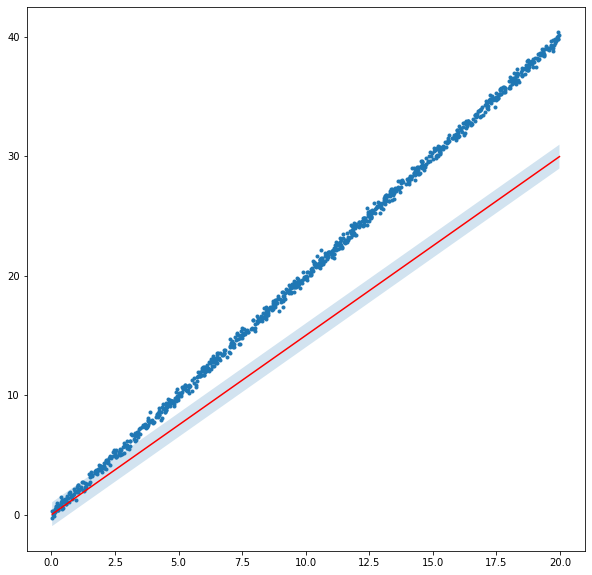

In [187]:
y_hat = (X.T @ jnp.array([beta_learned_f1])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [ ]:
beta_init = -1045.43
beta_learned_f2 = train_lin_reg(target_f2, lr=1e-5, iters= 10000, beta_init=beta_init, 
                                print_every=1000)

In [ ]:
y_hat = (X.T @ jnp.array([beta_learned_f2])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);

In [ ]:
beta_init = -1045.43
beta_learned_f3 = train_lin_reg(target_f3, lr=1e-5, iters= 10000, beta_init=beta_init, 
                                print_every=1000)

In [ ]:
y_hat = (X.T @ jnp.array([beta_learned_f3])).ravel()
X_sorted, y_sorted, y_hat_sorted = sort_data(X[0], y, y_hat)

plt.figure(figsize=(10, 10))
plt.plot(X_sorted, y_sorted, '.');
plt.plot(X_sorted, y_hat_sorted, 'r');
uncertainty = [1.] * len(y_hat_sorted)
plt.fill_between(X_sorted, y_hat_sorted.copy()-uncertainty, 
                 y_hat_sorted.copy()+uncertainty, alpha=0.2);